In [6]:
from rdkit import Chem
from rdkit.Chem import AllChem, Crippen, rdMolDescriptors, QED, Draw
import selfies as sf

# 1. example SELFIES
s = sf.encoder("O=[S-1]P(=O)(O)OP(O)P(=O)CP(=O)(O)OPP(=O)(O)[O+1]P(=O)(O)OP(=O)(O)OP(=O)(O)O")  # encode SMILES -> SELFIES

print("SELFIES:", s)


SELFIES: [O][=S-1][P][=Branch1][C][=O][Branch1][C][O][O][P][Branch1][C][O][P][=Branch1][C][=O][C][P][=Branch1][C][=O][Branch1][C][O][O][P][P][=Branch1][C][=O][Branch1][C][O][O+1][P][=Branch1][C][=O][Branch1][C][O][O][P][=Branch1][C][=O][Branch1][C][O][O][P][=Branch1][C][=O][Branch1][C][O][O]


In [7]:
# 2. decode SELFIES -> SMILES
sm = sf.decoder(s)
print("SMILES:", sm)

SMILES: O=[S-1]P(=O)(O)OP(O)P(=O)CP(=O)(O)OPP(=O)(O)[O+1]P(=O)(O)OP(=O)(O)OP(=O)(O)O


Mol OK: True
logP: 1.5070999999999999
TPSA: 346.62
QED: 0.06942167319934352
Fingerprint length: 2048
MMFF energy: -808.9415879998942


[12:45:29] UFFTYPER: Unrecognized charge state for atom: 1


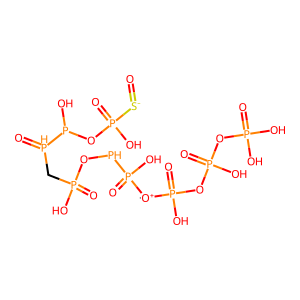

In [8]:
# 3. RDKit molecule
mol = Chem.MolFromSmiles(sm)
print("Mol OK:", mol is not None)

# 4. Sanitize
Chem.SanitizeMol(mol)

# 5. Basic descriptors
print("logP:", Crippen.MolLogP(mol))
# octanol–water partition coefficient (logP), which estimates lipophilicity (how hydrophobic a molecule is)
# higher logP → more lipophilic (less water-soluble)
print("TPSA:", rdMolDescriptors.CalcTPSA(mol))
# Topological Polar Surface Area (TPSA) -> reflects the polar surface of the molecule, mainly from oxygen and nitrogen atoms and their attached hydrogens
# important for drug absorption, permeability, and bioavailability
print("QED:", QED.qed(mol))
# Quantitative Estimate of Drug-likeness (QED)
# scores molecules from 0 to 1 based on multiple properties (like MW, logP, TPSA, H-bond donors/acceptors, rotatable bonds) to indicate how “drug-like” a molecule is

# 6. Fingerprint
fp = Chem.rdFingerprintGenerator.GetMorganGenerator(radius=2).GetFingerprint(mol)
print("Fingerprint length:", len(fp))

# 7. 3D + MMFF
# we need a 3D structure before using MMFF (Merck Molecular Force Field) because:
# MMFF is a force field method that calculates energies and optimizes geometry based on atomic positions in 3D space (bond lengths, angles, torsions, nonbonded interactions)
mol3D = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol3D)
AllChem.MMFFOptimizeMolecule(mol3D)
mmff_props = AllChem.MMFFGetMoleculeProperties(mol3D)
ff = AllChem.MMFFGetMoleculeForceField(mol3D, mmff_props)
print("MMFF energy:", ff.CalcEnergy())

# 8. draw the mol
Draw.MolToImage(mol)

Hydrogen cyanide (HCN)               C#N
Formaldehyde                         C=O
Methanol                              CO
Ethanol                               CCO
Acetaldehyde                          CC=O
Glycolaldehyde                        O=CCO
Formic acid                            O=C(O)
Urea                                   NC(=O)N
Ammonia                                N
Water                                   O
Glycine                                NCC(=O)O
Alanine                                CC(C(=O)O)N
Acetic acid                             CC(=O)O
Ethylamine                              CCN
Methanethiol                            CS
Pyruvic acid                            CC(=O)C(=O)O
Acetone                                 CC(=O)C
Carbon dioxide                          O=C=O
Carbonyl sulfide                        O=C=S
Phosphoric acid / orthophosphate        OP(=O)(O)O

In [4]:
def smiles_to_selfies(smiles_list):
    """
    Convert a list of SMILES strings to SELFIES strings.
    
    Parameters:
        smiles_list (list of str): List of SMILES molecules.
    
    Returns:
        list of str: Corresponding SELFIES strings.
    """
    selfies_list = []
    for smi in smiles_list:
        try:
            selfies_str = sf.encoder(smi)
            selfies_list.append(selfies_str)
        except Exception as e:
            print(f"Failed to encode SMILES '{smi}': {e}")
            selfies_list.append(None)
    return selfies_list

# Example usage
smiles_pool = ["C#N", "C=O", "CO", "CCO", "CC=O","O=CCO", "O=C(O)", "NC(=O)N", "N", "O", "NCC(=O)O", "CC(C(=O)O)N", "CC(=O)O", "CCN", "CS", "CC(=O)C(=O)O", "CC(=O)C", "O=C=O", "O=C=S", "OP(=O)(O)O"]
selfies_pool = smiles_to_selfies(smiles_pool)

for smi, s in zip(smiles_pool, selfies_pool):
    print(smi, "->", s)

print(selfies_pool)

C#N -> [C][#N]
C=O -> [C][=O]
CO -> [C][O]
CCO -> [C][C][O]
CC=O -> [C][C][=O]
O=CCO -> [O][=C][C][O]
O=C(O) -> [O][=C][O]
NC(=O)N -> [N][C][=Branch1][C][=O][N]
N -> [N]
O -> [O]
NCC(=O)O -> [N][C][C][=Branch1][C][=O][O]
CC(C(=O)O)N -> [C][C][Branch1][=Branch1][C][=Branch1][C][=O][O][N]
CC(=O)O -> [C][C][=Branch1][C][=O][O]
CCN -> [C][C][N]
CS -> [C][S]
CC(=O)C(=O)O -> [C][C][=Branch1][C][=O][C][=Branch1][C][=O][O]
CC(=O)C -> [C][C][=Branch1][C][=O][C]
O=C=O -> [O][=C][=O]
O=C=S -> [O][=C][=S]
OP(=O)(O)O -> [O][P][=Branch1][C][=O][Branch1][C][O][O]
['[C][#N]', '[C][=O]', '[C][O]', '[C][C][O]', '[C][C][=O]', '[O][=C][C][O]', '[O][=C][O]', '[N][C][=Branch1][C][=O][N]', '[N]', '[O]', '[N][C][C][=Branch1][C][=O][O]', '[C][C][Branch1][=Branch1][C][=Branch1][C][=O][O][N]', '[C][C][=Branch1][C][=O][O]', '[C][C][N]', '[C][S]', '[C][C][=Branch1][C][=O][C][=Branch1][C][=O][O]', '[C][C][=Branch1][C][=O][C]', '[O][=C][=O]', '[O][=C][=S]', '[O][P][=Branch1][C][=O][Branch1][C][O][O]']


In [5]:
# Filtering the sematic robust alphabet to include only biogenic atoms, ring and branch tokens
filtered_alphabet = {'[#Branch1]','[#Branch2]','[#Branch3]','[#C+1]','[#C-1]','[#C]','[#N+1]','[#N]','[#O+1]','[#P+1]','[#P-1]','[#P]','[#S+1]','[#S-1]','[#S]','[=Branch1]','[=Branch2]','[=Branch3]','[=C+1]','[=C-1]','[=C]','[=N+1]','[=N-1]','[=N]','[=O+1]','[=O]','[=P+1]','[=P-1]','[=P]','[=Ring1]','[=Ring2]','[=Ring3]','[=S+1]','[=S-1]','[=S]','[Branch1]','[Branch2]','[Branch3]','[C+1]','[C-1]','[C]','[N+1]','[N-1]','[N]','[O+1]','[O-1]','[O]','[P+1]','[P-1]','[P]','[Ring1]','[Ring2]','[Ring3]','[S+1]','[S-1]','[S]'}